# Dimensionality reduction

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder) and uses them as input for a 
dimensionality reduction algorithm, to generate projectsion of the embeddings

In [1]:
#Weight & Biases
import wandb

#Yaml
from yaml import load, FullLoader

#Embeddings
from dvats.all import *
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits
from fastcore.all import *

#Dimensionality reduction
from tsai.imports import *

#Clustering
import hdbscan

In [2]:
check_memory_usage = True

In [3]:
if check_memory_usage:
    import nbs_pipeline.utils.memory as mem
    import torch 
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

Used mem: 2010
Used mem: 24576
Memory Usage: [█-------------------] 8%


In [4]:
#Get W&B API
api = wandb.Api()

## Config parameters

Put here everything that could be needed if this notebook

TODO: Change to config.py & tml version when fixed

In [5]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = os.environ['WANDB_ENTITY'], # The entity to use for wandb,
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for wandb,
    dr_artifact_name = None, # * Set to None for using the default one (encoder validation set)
    enc_artifact = 'mi-santamaria/deepvats/mvp-SWV:latest', # Name:version of the encoder artifact
    n_neighbors = 15, #UMAP
    min_dist = 0.1, #UMAP,
    random_state = 1234, # UMAP
    cpu = False
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

## Run

In [6]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="04_dimensionality_reduction"
runname = name
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"

In [7]:
run_dr = wandb.init(
    entity=config.wandb_entity,
    project=config.wandb_project if config.use_wandb else 'work-nbs', 
    group=config.wandb_group,
    allow_val_change=True, 
    job_type='dimensionality_reduction', 
    mode='online' if config.use_wandb else 'disabled',
    anonymous = 'never' if config.use_wandb else 'must',
    config=config,
    resume = 'allow',
    name = runname
    #resume=False
)
config_dr = wandb.config # Object for storing hyperparameters

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/04_dimensionality_reduction.ipynb.


In [8]:
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config_dr.use_wandb else api.artifact

Restore the encoder model and its associated configuration

In [9]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')
enc_artifact.metadata

{'r': 0.71,
 'w': 900,
 'MVP': {'r': 0.71,
  'lm': 3,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': True,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': False,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'ref': {'hash': '9067667917391373491',
  'type': "<class 'fastai.learner.Learner'>"},
 'freq': '4s',
 'alias': 'solar_4_seconds',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 100,
 'frozen': False,
 'mvp_ws': [450, 900],
 'stride': 450,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7fa8ec63a590>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELoss(

In [10]:
enc_artifact.name

'mvp-SWV:v23'

In [11]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [12]:
enc_logger = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_logger.config['train_artifact'], type='dataset')
if enc_logger.config['valid_artifact'] is not None:
    enc_artifact_valid = artifacts_gettr(enc_logger.config['valid_artifact'], type='dataset')
    print("enc_artifact_valid:", enc_artifact_valid.name)
print("enc_artifact_train: ", enc_artifact_train.name)

enc_artifact_train:  solar_4_seconds:v0


Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [13]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = artifacts_gettr(config_dr.dr_artifact_name)
else:
    dr_artifact = enc_artifact_train
dr_artifact.name

'solar_4_seconds:v0'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [14]:
df = dr_artifact.to_df()
df.head()

wandb: Downloading large artifact solar_4_seconds:latest, 112.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


,0
2019-08-01 00:00:03,0.0
2019-08-01 00:00:07,0.0
2019-08-01 00:00:11,0.0
2019-08-01 00:00:15,0.0
2019-08-01 00:00:19,0.0


In [15]:
df.shape

(7397222, 1)

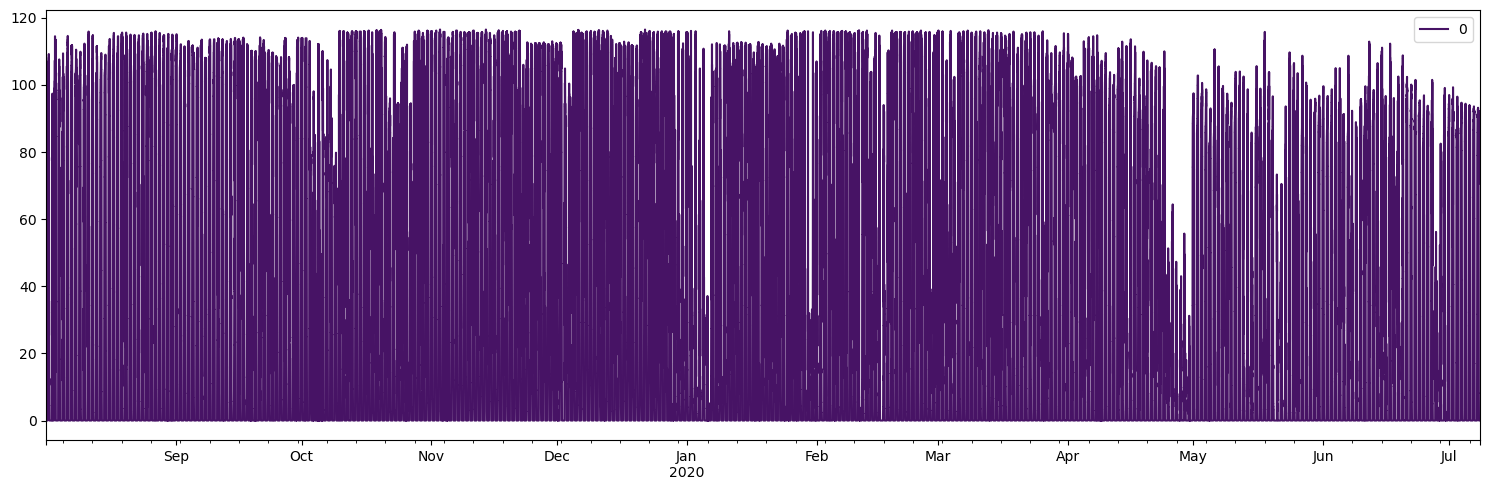

In [16]:
# Show time series plot
fig, ax = plt.subplots(1, figsize=(15,5), )
cmap = matplotlib.colormaps.get_cmap('viridis')
df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
# rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
# ax.add_patch(rect)
plt.tight_layout()
plt.legend()
plt.show()

In [17]:
import time

In [18]:
w = enc_logger.config['w']
print(w)

900


In [19]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 2010
Used mem: 24576
Memory Usage: [█-------------------] 8%


In [20]:
t_start = time.time()
enc_input, _ = prepare_forecasting_data(df, fcst_history = w)
t_end = time.time()
t = t_end - t_start
print("SW start | " , t_start, " | end ", t_end, "total (secs): ", t)
print(enc_input.shape)

SW start |  1701975176.3200297  | end  1701975176.3213537 total (secs):  0.0013239383697509766
(7396322, 1, 900)


In [21]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 2010
Used mem: 24576
Memory Usage: [█-------------------] 8%


### Getting the embeddings (activations) from the encoder

In [22]:
stride = enc_logger.config['stride']
batch_size = enc_logger.config['batch_size']

In [23]:
print(stride)
print(batch_size)

450
512


In [24]:
print(enc_input.shape)
print(enc_artifact.name)

(7396322, 1, 900)
mvp-SWV:v23


In [25]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 2010
Used mem: 24576
Memory Usage: [█-------------------] 8%


In [26]:
i = 0
for a in range (enc_input.shape[0]):
    for b in range (enc_input.shape[1]):
        for c in range (enc_input.shape[2]):
            if enc_input[a,b,c] != 0: 
                print(a,b,c, enc_input[a,b,c])
                i+=1
                if i == 10: break
        if i == 10: break
    if i == 10: break

5403 0 899 2.5
5404 0 898 2.5
5404 0 899 2.5
5405 0 897 2.5
5405 0 898 2.5
5405 0 899 2.5
5406 0 896 2.5
5406 0 897 2.5
5406 0 898 2.5
5406 0 899 2.5


In [27]:
chunk_max = 10000000
shape = enc_input.shape
chunk_size_ = min(shape[1]*shape[2],chunk_max/(shape[1]*shape[2]))
N = max(3200,np.floor(chunk_size_/32))
chunk_size = N*32
chunk_size

102400

In [28]:
t_start = time.time()
embs = get_enc_embs_set_stride_set_batch_size(
    enc_input, 
    enc_learner, 
    stride = stride,
    batch_size = batch_size,
    cpu=config.cpu,
    to_numpy = True, 
    print_flag = False,
    time_flag = True,
    chunk_size = chunk_size
)
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end ", t_end, "total (secs): ", t)

get_enc_embs_set_stride_set_batch_size 12.719286441802979 seconds
GE start |  1701975177.8069806  | end  1701975190.9818022 total (secs):  13.174821615219116


In [29]:
embs.shape

(16437, 128)

In [30]:
embs[0,0:20]

array([9.3807845e-05, 0.0000000e+00, 1.8430209e-02, 1.9507964e-01,
       0.0000000e+00, 1.4109529e+00, 0.0000000e+00, 4.2354417e+00,
       1.8621813e+00, 0.0000000e+00, 2.6404362e-02, 0.0000000e+00,
       0.0000000e+00, 9.6108222e-01, 1.3771579e+00, 0.0000000e+00,
       5.1861262e-01, 0.0000000e+00, 5.3743500e-01, 4.1372851e-03],
      dtype=float32)

In [31]:
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end (next cell) ", t_end, "total (secs): ", t)

GE start |  1701975177.8069806  | end (next cell)  1701975191.0121326 total (secs):  13.205152034759521


In [32]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 2448
Used mem: 24576
Memory Usage: [██------------------] 10%


In [33]:
run_dr.finish()

In [34]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)

### Dimensions check

In [35]:
print(embs.shape)
print(enc_input.shape)

(16437, 128)
(7396322, 1, 900)


In [36]:
embs[0]

array([9.3807845e-05, 0.0000000e+00, 1.8430209e-02, 1.9507964e-01,
       0.0000000e+00, 1.4109529e+00, 0.0000000e+00, 4.2354417e+00,
       1.8621813e+00, 0.0000000e+00, 2.6404362e-02, 0.0000000e+00,
       0.0000000e+00, 9.6108222e-01, 1.3771579e+00, 0.0000000e+00,
       5.1861262e-01, 0.0000000e+00, 5.3743500e-01, 4.1372851e-03,
       7.5966483e-01, 0.0000000e+00, 3.9131105e-02, 0.0000000e+00,
       1.4107014e-02, 1.1679626e-02, 1.2607830e+00, 2.4809498e-01,
       0.0000000e+00, 1.9149052e-02, 6.4864880e-01, 1.5065639e+00,
       0.0000000e+00, 0.0000000e+00, 1.0535666e+00, 1.8918542e-02,
       7.8772163e-01, 1.9275296e-02, 1.8171771e-01, 0.0000000e+00,
       1.4320878e-02, 1.4285339e+00, 3.0776393e-01, 9.9533421e-01,
       6.1341298e-01, 5.4692770e-03, 0.0000000e+00, 2.5893240e+00,
       1.7150058e+00, 1.5798280e+00, 1.8082676e-02, 2.7897491e+00,
       0.0000000e+00, 0.0000000e+00, 1.0185721e-02, 1.5186176e+00,
       3.5471737e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [37]:
#Dimensions check
num_inputs = np.ceil(enc_input.shape[0]/stride)
num_embs = embs.shape[0]
test_eq(num_inputs, num_embs )
print(num_inputs, num_embs)

16437.0 16437


Average embeddings in the time dimension, if needed

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [38]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}

In [39]:
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(16437, 128)

In [40]:
prjs_umap = get_UMAP_prjs(
    input_data = embs_no_nan, 
    cpu= False, 
    print_flag = True, 
    **umap_params
)
prjs_umap.shape

--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234}
200eb7e61ac3c7faa22e2f7aa0bf8309
Used mem: 2448
Used mem: 24576
Memory Usage: [██------------------] 10%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7ff4cff7fba0>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': None, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'spectral', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': -1, 'target_weight': 0.5, 'target_metric': 'categorical', 'hash_input': False, 'random_state': 822569775, 'callback': None, 'metric': 'euclidean', 'metric_kwds': None, 'precomputed_knn': None}
------- reducer --------
Used mem: 2472
Used mem: 24576
Memory Usage: [██------------------] 10%
prjs checksum  49be0

(16437, 2)

In [41]:
umap_params

{'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234}

In [42]:
prjs_umap[0:10] # En R head(res[1,],10)

array([[-5.2777007e+03,  9.2256085e+02],
       [-1.7568268e+02, -5.1156079e+03],
       [ 2.3918895e+04, -1.5807799e+04],
       [-3.3926195e+04, -3.2297775e+04],
       [-2.8251699e+03, -3.0244756e+03],
       [-1.7275365e+04, -1.5154948e+04],
       [-2.1982523e+04, -3.1266646e+04],
       [-2.3962888e+03,  8.2787244e+02],
       [-1.6043270e+01, -2.5328545e+01],
       [-7.0353127e+01, -4.3729816e+01]], dtype=float32)

In [43]:
#prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)
#prjs.shape

Save the projections as an artifact

In [44]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
metadata=dict(run_dr.config)), aliases=f'run-{run.project}-{run.id}')

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [45]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [46]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 5, #100,
    'min_samples' : 7,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard'
}

In [47]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
clusters_labels

array([-1, -1, -1, ..., 33, 33, 33])

In [48]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs_umap.shape[0])

In [49]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '-6761158255303741089', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([ArtifactManifestEntry(path='-6761158255303741089', digest='aqjIR6QlqIoG0sqKt8z9zA==', ref='file:///home/macu/data/wandb_artifacts/-6761158255303741089', birth_artifact_id=None, size=131656, extra={}, local_path=None)]))

In [50]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [51]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [52]:
#| export
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

[ -1  29 182 219 229 137 209 215 251 116 125  79  87  99  81 224 175 135
 262  53  31  47 431 448  46 186 304 188 165 195 210  35   5   0 136 243
 316 266 151 263 216  64 237 337 352 138  10 408   1 149 350 213 166 144
 119 139 295 299 354 218 193 398  48 402 147 214 244 308 212 172 311 117
 254 305 114 401  14  16  21 436 409 148 310 206 208  89  77  82 301 198
  58 390 367 374  55 371 388 231 348  22 417 317 174  96  90  57 377 379
 378 278 200  41 395  52   9 416 332 225  85  95 204 330 196 437 441 236
  74 167 111 118  71 268 328   6  11 433 220 146 253 133 103  75 155 152
 127  54  30  40  36 427 351 123 202 333 272  73 446  33 140 163 124  88
 381 385 197  66 257 331 267  34 393 430 207 170  83 276 273 406 425  39
 100 226 274 199 453 399 112 102  93 412 410  91 384 373 372   2 279  65
 386 131  78  68  62 357  56 440 397  15 426  12  72 319  60 364  70 403
  24 287 113 275 338 282 128 404  26 447 320 192 247 342 162 249 329  86
 106 387 132 451 394 435 194 303  45  23 318 368 24

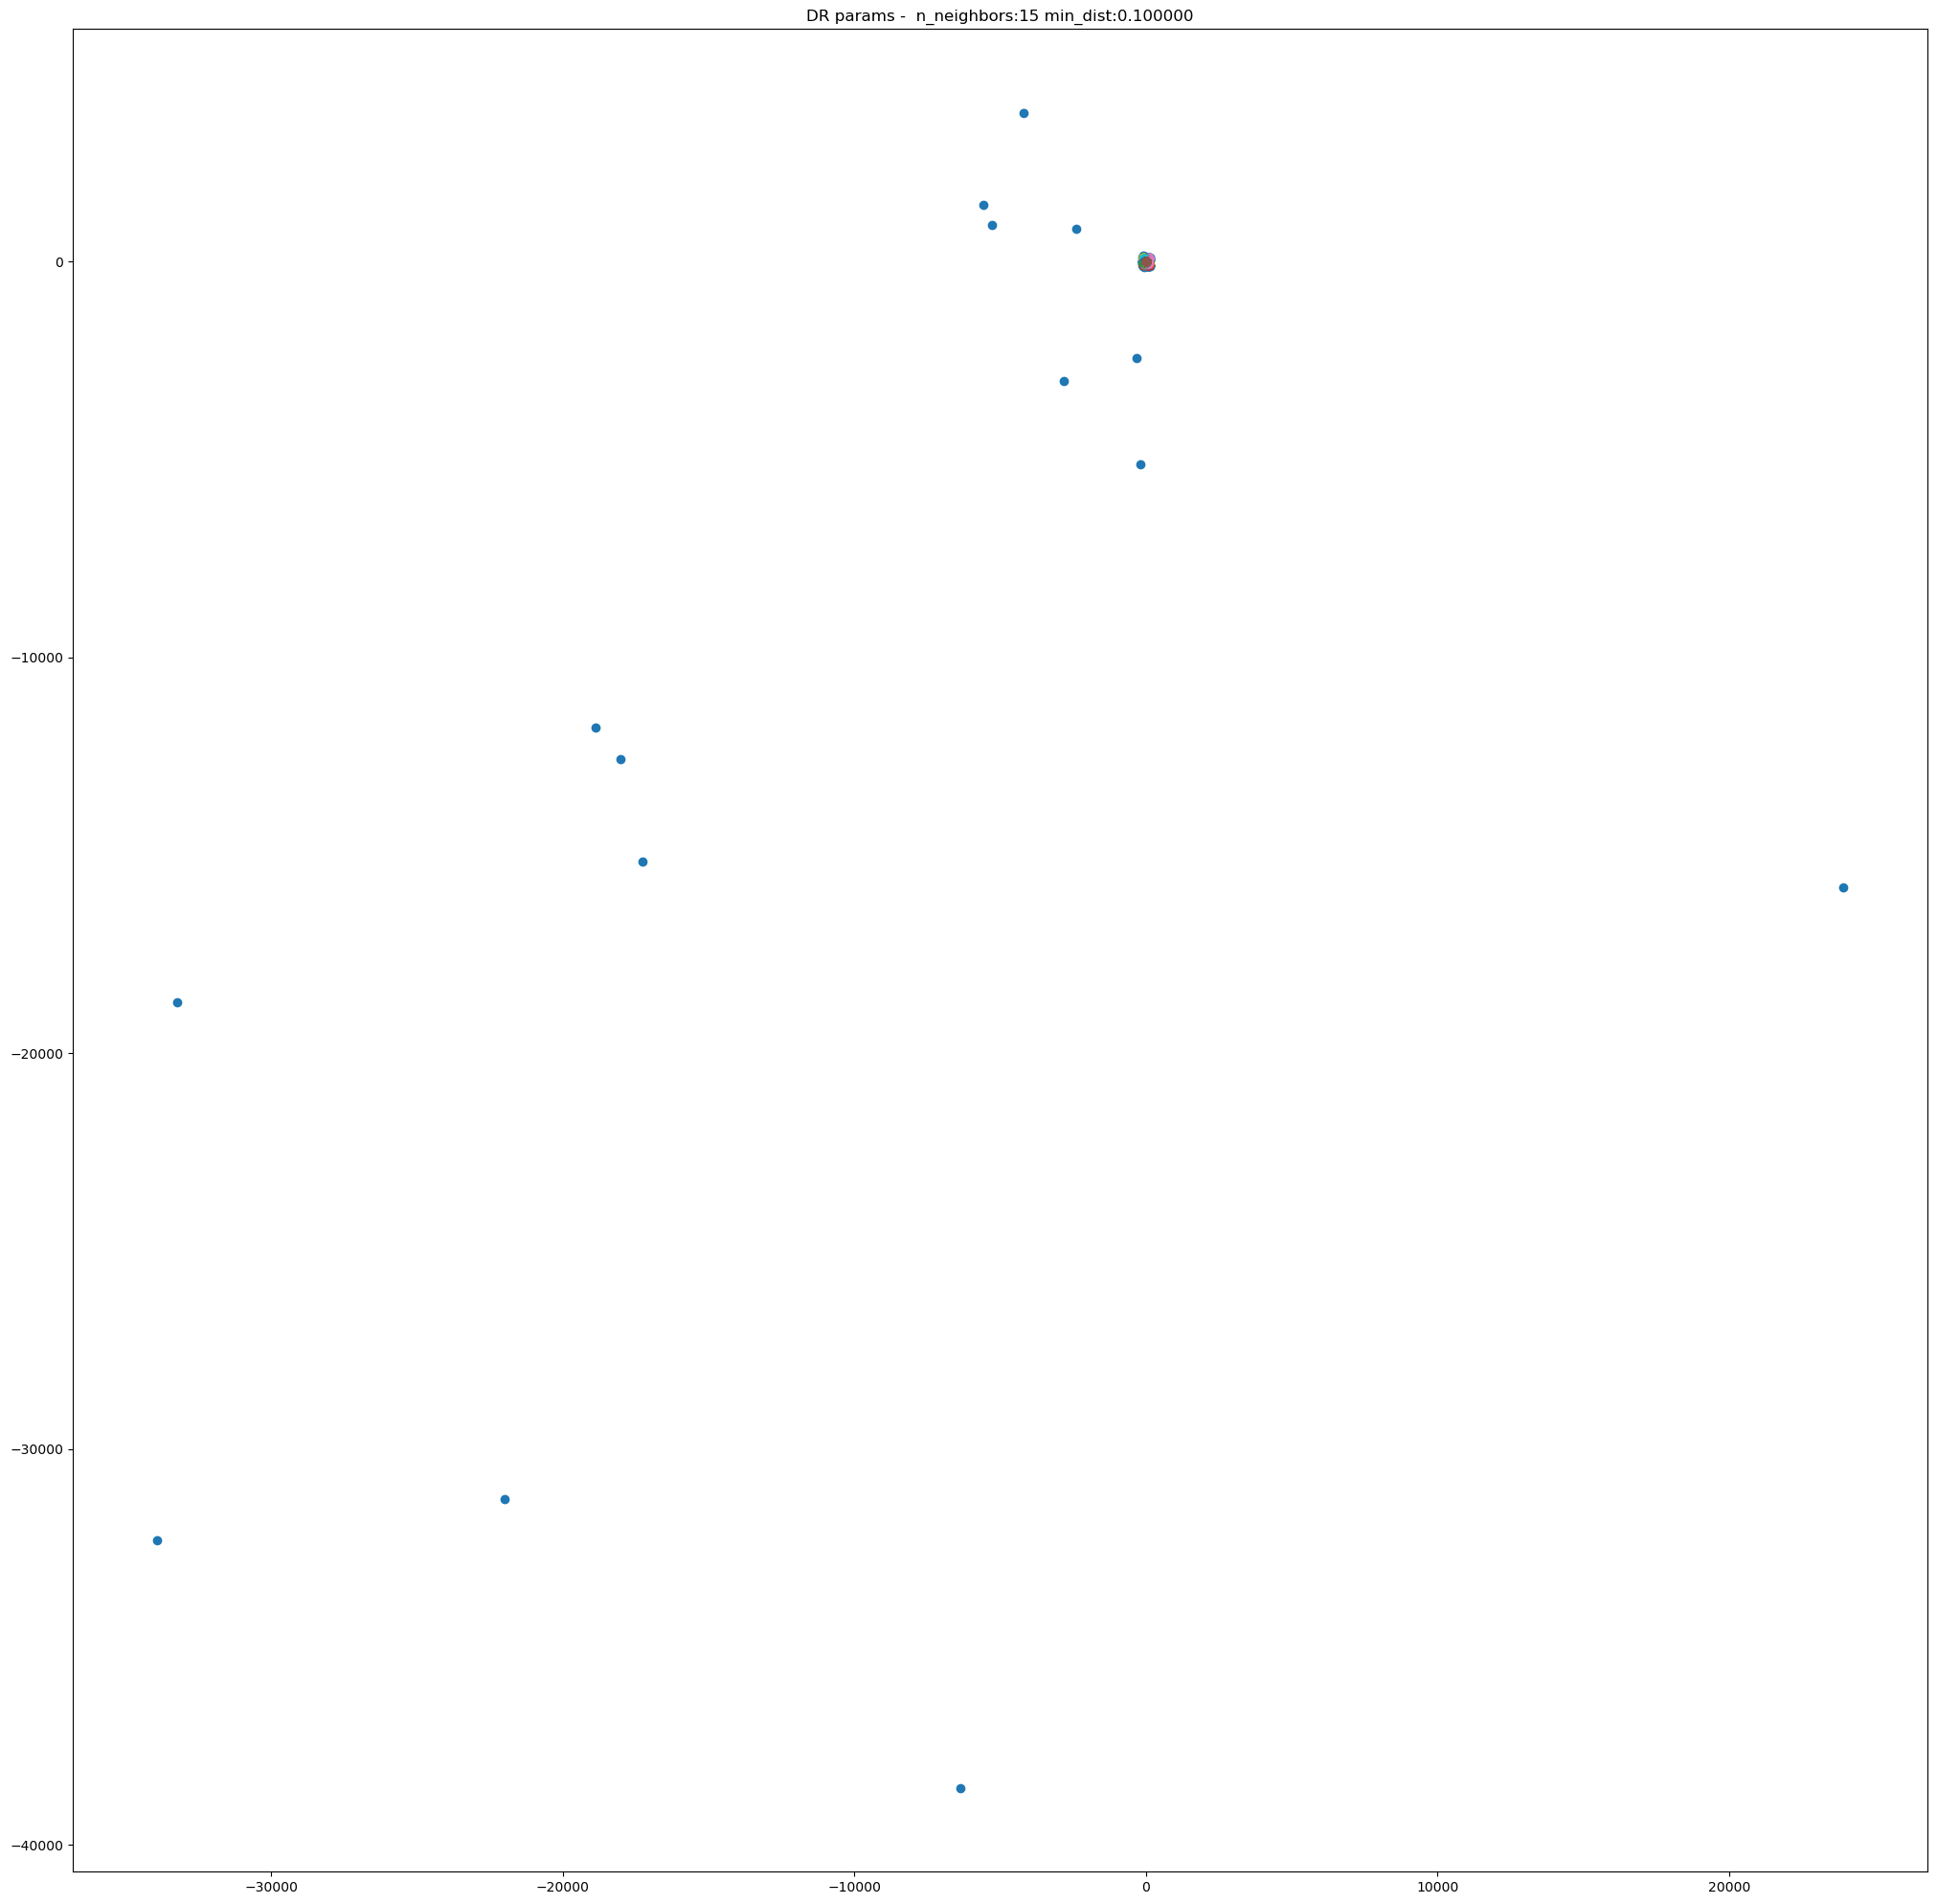

In [53]:
prjs_plt = plot_projections_clusters(prjs_umap, clusters_labels, umap_params)

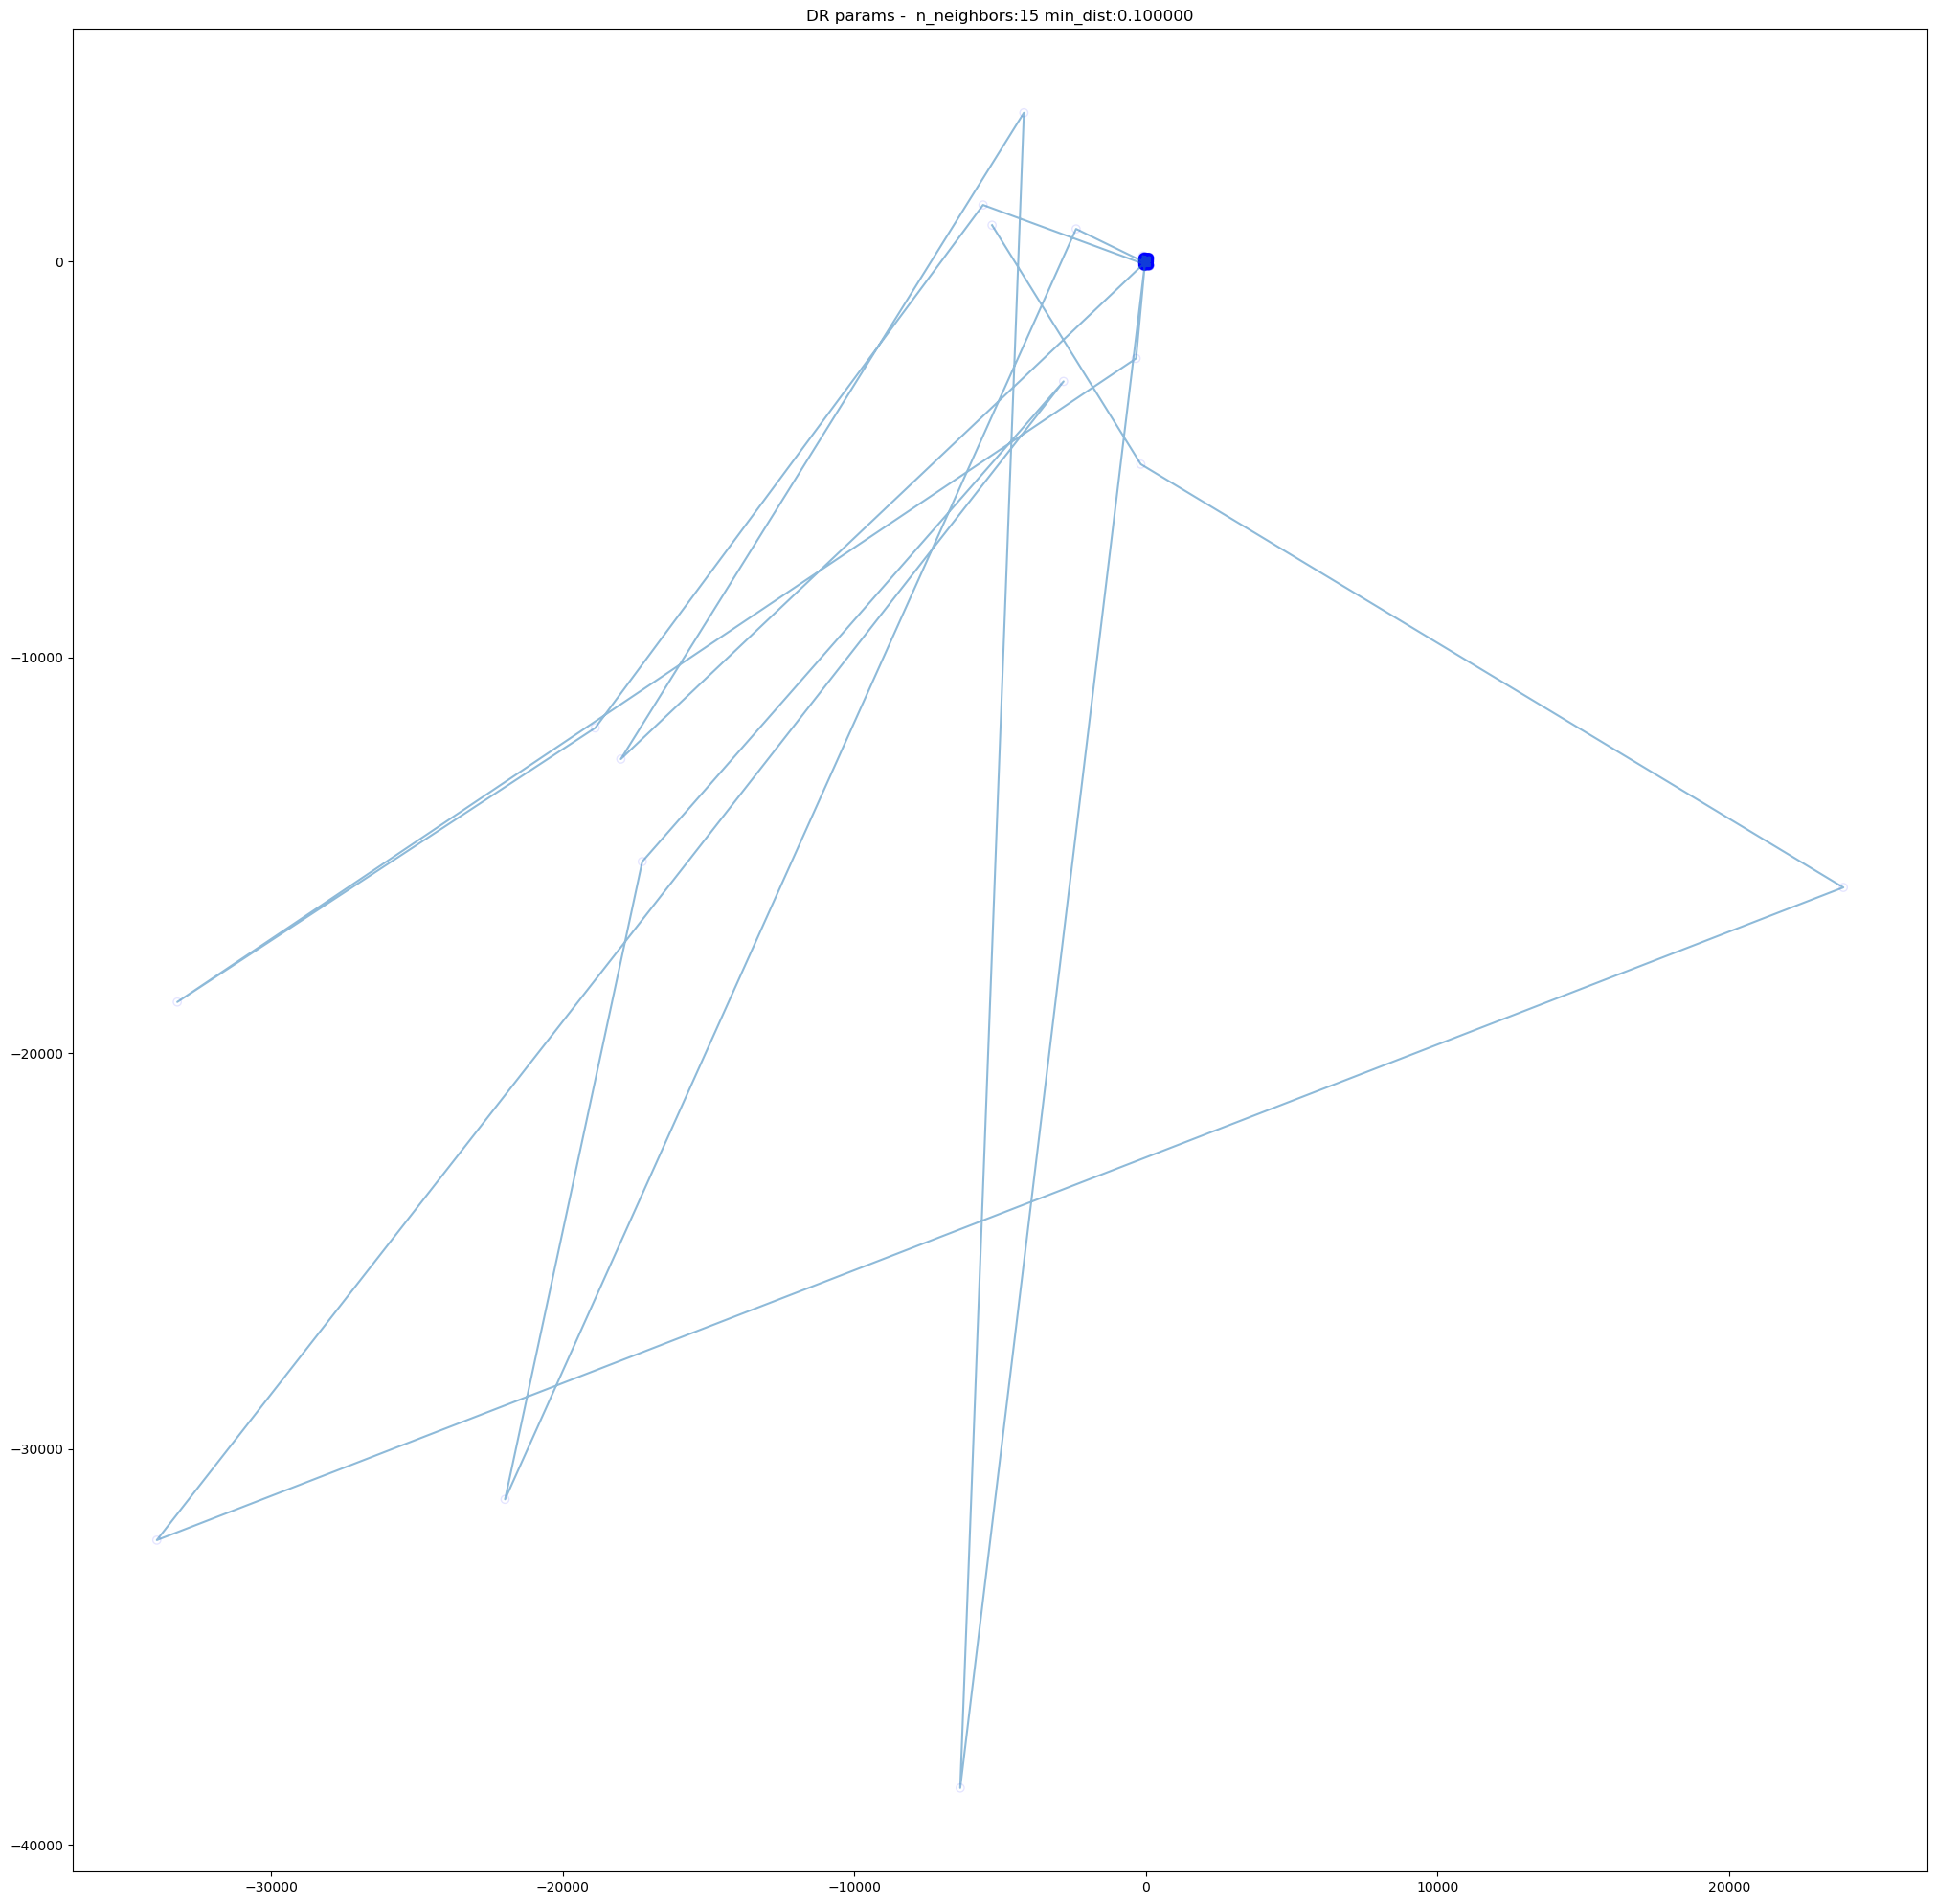

In [54]:
prjs_plt = plot_projections(prjs_umap, umap_params)

Log this plot as part of the current wandb run

In [55]:
#| hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [56]:
#| hide
run_dr.finish()

# Explainability with SHAP (future work)

In [57]:
# %matplotlib inline

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)

# ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
# ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
# ax.set_title('Select the point you want to visualize as a time window in the original space')

Make the plot interactive to allow selection of subsets of the plot

In [58]:
# selected_indices = None
# selected_points = None

# def onpick(event):
#     global selected_points
#     thisline = event.artist
#     xdata = thisline.get_xdata()
#     ydata = thisline.get_ydata()
#     global selected_indices
#     selected_indices = event.ind
#     selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
#     print('onpick points (first):', selected_points[0])

# fig.canvas.mpl_connect('pick_event', onpick)

# plt.show()
# fig.tight_layout()
# fig.savefig(f'../img/w={w}.png')

## Hyperparameter tuning for the dimensionality reduction

There are a number of parameters that can be set for the UMAP algorithm. The major 
ones are `n_neighbors` and `min_dist`. Thus, we will carry out a hyperparameter 
sweep in Weights and Biases for these two parameters. Note that there is no objective
way of deciding that some embeddings are better than others. Thus, we must rely on our
intuition by visualizing the 2D plots of each of the runs in the sweep.

The first thing we need is gather all the pipeline of the previous section into a function


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [59]:
# selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
# selected_window

### Visualizing all the variables in the time window (default)

In [60]:
# %matplotlib inline
# g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
# g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables

In high dimensional time series, not only is interesting to see the window associated to a point in the 2D space, but also it is extremely important to spot which variables are mainly causing that the window is positioned in that point of the 2D space.

Since UMAP does not provide capabilities to understand feature importance, there are [different ways](https://stats.stackexchange.com/questions/438025/understand-important-features-in-umap) to tackle this problem:

1. Use another dimensionality reduction technique that provides importance, such as [sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

2. Create a surrogate model on top of the inputs/output of UMAP and explain it using XAI techniques. We will try here this option.

The idea is to have a surrogate model that takes the multivariate time series as input and produces the associated points in the 2D space as ouput. Since we already have a Deep Convolutional Autoencoder (DCAE) that takes a multivariate time series as input, and it contains the latent features that represent that input, we can use it for the surrogate. We will use the intermediate model that goes from the input to the layer containing the latent space, and then add a `Dense` layer with 2 units and linear activation.

In [61]:
#export
# def train_surrogate_model(dcae, embeddings, lat_ln='latent_features'):
#     "Train a surrogate model that learns the `embeddings` from the latent features contained in the layer \
#     `lat_ln` of a previously trained Deep Convolutional AutoEncoder `dcae`"
#     x = dcae.get_layer(lat_ln).output
#     x = Dense(units=embeddings.shape[1], activation='linear')(x)
#     surrogate_model = Model(dcae.input, x)
#     l_nms = [layer.name for layer in surrogate_model.layers]
#     layer_idx = l_nms.index(lat_ln)
#     # The layers that are already trained from the autoencoder must be `frozen`
#     for layer in surrogate_model.layers[:layer_idx]:
#         layer.trainable = False
#     return surrogate_model

In [62]:
# sm = train_surrogate_model(m, embeddings, lat_ln='latent_features')

In [63]:
# test.equals(sm.input.shape, m.input.shape)
# test.equals(sm.output.shape[1], embeddings.shape[1])
# l_nms = [layer.name for layer in sm.layers]
# layer_idx = l_nms.index('latent_features')
# test.all_equal([layer.trainable for layer in sm.layers], \
#                np.repeat([False, True], [layer_idx + 1, len(sm.layers) -1 -layer_idx]))

Configure the training hyperparameters

In [64]:
# loss = 'mean_squared_error'
# opt = 'adam'
# bs = 100
# epochs = 10
# val = .2

In [65]:
# sm.output_shape

In [66]:
# input_data.shape

In [67]:
# embeddings.shape

In [68]:
# sm.fit(x=input_data, y=embeddings, batch_size=bs, validation_split=val, epochs=epochs, callbacks=[WandbCallback()])

In [69]:
# import innvestigate

In [70]:
# analyzer = innvestigate.create_analyzer("gradient", intermediate_model)

In [71]:
# asd= innvestigate.create_analyzer("gradient", m)

In [72]:
# from keras.datasets import mnist

In [73]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [74]:
# x_train.shape

In [75]:
# input_data[np.random.choice(input_data.shape[0], 100, replace=False)].shape

In [76]:
# import shap

In [77]:
# background = input_data[np.random.choice(input_data.shape[0], 100, replace=False)]
# e = shap.DeepExplainer(intermediate_model, background)

In [78]:
# shap_values = e.shap_values(input_data[0:4])

In [79]:
# shap_values[0][0]

In [80]:
print("Execution ended")
beep(1)

Execution ended


In [81]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)